Card(header=Markdown, header_background='#f0f0f0', width=998)
    [0] Row
        [0] Column
            [0] Bokeh(Figure)
            [1] Card(header=Markdown, header_background='#f0f0f0', width=700)
                [0] Bokeh(DataTable, height=152)
        [1] Card(header=Markdown, header_background='#f0f0f0', width=250)
            [0] Bokeh(DataTable)
            [1] Bokeh(DataTable)
            [2] Bokeh(DataTable)
            [3] Column(margin=(0, 0, 0, 0), width=225)
                [0] MultiChoice(margin=(0, 10, 0, 10), max_items=1, name='what event happened?', options=['bad_touch', ...], width=230)
                [1] MultiChoice(margin=(0, 10, 0, 10), max_items=1, name='was the event s..., options=['success', 'failure'], width=230)
            [4] Row(width=250)
                [0] Button(name='Add Frame')
                [1] Button(name='Remove Last')
            [5] FileDownload(callback=<function download_frame a..., filename='frames.csv', label='Download frames.csv')
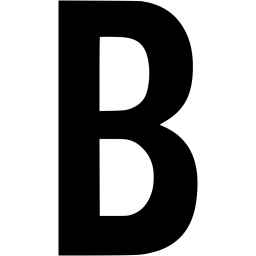
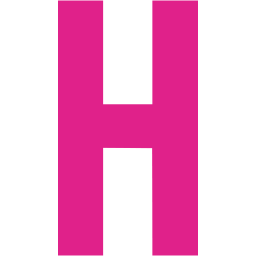
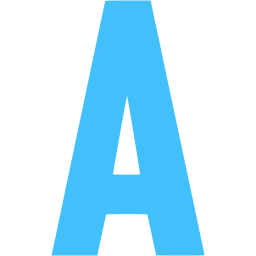

In [1]:
from bokeh.models.glyphs import Circle
from bokeh.plotting import figure, show, output_notebook, Column, Row
from bokeh import events
from bokeh.models import DataTable, TableColumn, PointDrawTool, ColumnDataSource, Range1d, NumberFormatter
from bokeh.models.glyphs import Circle, Patches, Wedge
import panel as pn

import pandas as pd
import numpy as np
from math import pi
from io import StringIO, BytesIO

def draw_pitch(width=700, height=500, measure='metres', fill_color='#FFFFFF', fill_alpha=0.5, hpad=0.25, vpad=0.25,
               line_color='grey', goalline_color='#969696', line_alpha=1, hspan=[-52.5, 52.5], vspan=[-34, 34], arcs=True):
    '''
    -----
    Draws and returns a pitch on a Bokeh figure object with width 105m and height 68m
    p = drawpitch()
    -----
    If you are using StatsBomb Data with a 120x80yard pitch, use:
    measure = 'SB'
    -----
    If you are using Opta Data, use:
    measure = 'Opta'
    -----
    If you are using any other pitch size, set measure to yards or metres
    for correct pitch markings and
    hspan = [left, right] // eg. for SBData this is: hspan = [0, 120]
    vspan = [bottom, top] //
    to adjust the plot to your needs.
    -----
    set arcs = False to not draw the penaltybox arcs
    '''

    # measures:
    # goalcenter to post, fiveyard-box-length, fiveyard-width,
    # box-width, penalty-spot x-distance, circle-radius

    if measure == 'yards':
        measures = [4, 6, 10, 18, 42, 12, 10]
    elif (measure == 'SBData') | (measure == 'StatsBomb')|(measure == 'statsbomb')|(measure == 'SB'):
        measures = [4, 6, 10, 18, 44, 12, 10]
        hspan = [0, 120]
        vspan = [0, 80]
    elif measure == 'Opta':
        measures = [4.8, 5.8, 13.2, 17, 57.8, 11.5, 8.71]
        hspan = [0, 100]
        vspan = [0, 100]
    else:  # if measure = metres or whatever else
        measures = [3.66, 5.5, 9.16, 16.5, 40.32, 11, 9.15]

    hmid = (hspan[1]+hspan[0])/2
    vmid = (vspan[1]+vspan[0])/2

    p = figure(width=width,
               height=height,
               x_range=Range1d(hspan[0]-hpad, hspan[1]+hpad),
               y_range=Range1d(vspan[0]-vpad, vspan[1]+vpad),
               tools=[])

    boxes = p.quad(top=[vspan[1], vmid+measures[2], vmid+measures[4]/2, vmid+measures[4]/2, vmid+measures[2]],
                   bottom=[vspan[0], vmid-measures[2], vmid-measures[4]/2, vmid-measures[4]/2, vmid-measures[2]],
                   left=[hspan[0], hspan[1]-measures[1], hspan[1]-measures[3], hspan[0]+measures[3], hspan[0]+measures[1]],
                   right=[hspan[1], hspan[1], hspan[1], hspan[0], hspan[0]],
                   color=fill_color,
                   alpha=[fill_alpha, 0, 0, 0, 0],
                   line_width=2,
                   line_alpha=line_alpha,
                   line_color=line_color)
    boxes.selection_glyph = boxes.glyph
    boxes.nonselection_glyph = boxes.glyph

    # middle circle
    p.circle(x=[hmid], y=[vmid], radius=measures[6], color=line_color, line_width=2, fill_alpha=0, fill_color='grey', line_color=line_color)

    if arcs is True:
        p.arc(x=[hspan[0]+measures[5], hspan[1]-measures[5]], y=[vmid, vmid],
              radius=measures[6],
              start_angle=[(2*pi-np.arccos((measures[3]-measures[5])/measures[6])), pi - np.arccos((measures[3]-measures[5])/measures[6])],
              end_angle=[np.arccos((measures[3]-measures[5])/measures[6]), pi + np.arccos((measures[3]-measures[5])/measures[6])],
              color=line_color,
              line_width=2)

    p.circle([hmid, hspan[1]-measures[5], hspan[0]+measures[5]], [vmid, vmid, vmid], size=5, color=line_color, alpha=1)
    # midfield line
    p.line([hmid, hmid], [vspan[0], vspan[1]], line_width=2, color=line_color)
    # goal lines
    p.line((hspan[1], hspan[1]), (vmid+measures[0], vmid-measures[0]), line_width=6, color=goalline_color)
    p.line((hspan[0], hspan[0]), (vmid+measures[0], vmid-measures[0]), line_width=6, color=goalline_color)

    p.grid.visible = False
    p.xaxis.visible = False
    p.yaxis.visible = False

    return p

pn.extension()

pitch_width = 105*7
pitch_height = 68*7

p = draw_pitch(width=pitch_width, height=pitch_height)

pink = '#e0218a'
blue = '#42c0fb'

sourceH = ColumnDataSource({'x': [], 'y': [], 'team': []})
sourceA = ColumnDataSource({'x': [], 'y': [], 'team': []})
sourceB = ColumnDataSource({'x': [], 'y': [], 'team': []})

rendererH = p.circle(x='x', y='y',
                    source=sourceH,
                    color='#e0218a',
                    size=10)

rendererA = p.circle(x='x', y='y',
                    source=sourceA,
                    color='#42c0fb',
                    size=10)

rendererB = p.circle(x='x', y='y',
                    source=sourceB,
                    color='#000000',
                    size=10)

formatter = NumberFormatter(format='0.00')
columns = [TableColumn(field="x", title="x", formatter=formatter),
           TableColumn(field="y", title="y", formatter=formatter),
           TableColumn(field='team', title='team')]

tableH = DataTable(source=sourceH, columns=columns, editable=True, height=175, width=200)
tableA = DataTable(source=sourceA, columns=columns, editable=True, height=175, width=200)
tableB = DataTable(source=sourceB, columns=columns, editable=True, height=50, width=200)

table_out_columns = ['Ball_x', 'Ball_y','H_0_x', 'H_0_y',
                    'H_1_x', 'H_1_y', 'H_2_x', 'H_2_y', 'H_3_x', 'H_3_y', 'H_4_x',
                    'H_4_y', 'H_5_x', 'H_5_y', 'H_6_x', 'H_6_y', 'H_7_x', 'H_7_y',
                    'H_8_x', 'H_8_y', 'H_9_x', 'H_9_y', 'H_10_x', 'H_10_y',
                    'A_0_x', 'A_0_y', 'A_1_x', 'A_1_y', 'A_2_x',
                    'A_2_y', 'A_3_x', 'A_3_y', 'A_4_x', 'A_4_y', 'A_5_x', 'A_5_y',
                    'A_6_x', 'A_6_y', 'A_7_x', 'A_7_y', 'A_8_x', 'A_8_y', 'A_9_x',
                    'A_9_y', 'A_10_x', 'A_10_y', 'type_name', 'result_name']

sourceOUT = ColumnDataSource({col: [] for col in table_out_columns})

table_out_tablecolumns = [TableColumn(field=col, title=col, formatter=formatter) for col in table_out_columns[:-2]]
table_out_tablecolumns.extend([TableColumn(field=col, title=col) for col in table_out_columns[-2:]])

tableOUT = DataTable(source=sourceOUT,
                     columns=table_out_tablecolumns,
                     editable=True, height=100, width=pitch_width-50)


draw_toolH = PointDrawTool(renderers=[rendererH],
                           empty_value='H', num_objects=11, custom_icon='static/icons/Pink_H_Icon.png')

draw_toolA = PointDrawTool(renderers=[rendererA],
                           empty_value='A', num_objects=11, custom_icon='static/icons/Blue_A_Icon.png')

draw_toolB = PointDrawTool(renderers=[rendererB],
                           empty_value='B', num_objects=1, custom_icon='static/icons/Black_B_Icon.png')

p.add_tools(draw_toolH)
p.add_tools(draw_toolA)
p.add_tools(draw_toolB)

p.toolbar.active_tap = draw_toolH

global dfs
dfs = []

def remove_last_frame(event):
    global dfs
    if len(dfs) > 1:
        dfs = dfs[:-1]
        df = pd.concat(dfs).reset_index(drop=True)
        sourceOUT.data = dict(df)
    elif len(dfs) == 1:
        dfs = []
        sourceOUT.data = {col: [] for col in table_out_columns}

def add_frame(event):
    df = pd.concat([pd.DataFrame(sourceH.data), pd.DataFrame(sourceA.data), pd.DataFrame(sourceB.data)])
    df['name'] = df.team + '_' + df.index.astype('str')
    df = df.drop('team', axis=1)
    df = pd.melt(df, id_vars=['name'])
    df['name'] = df['name'] + '_' + df['variable']
    df = df.drop('variable', axis=1).set_index('name').T
    df = df.rename({'B_0_x': 'Ball_x', 'B_0_y': 'Ball_y'}, axis=1)
    df = df.reset_index(drop=True)
    df = df.reindex(table_out_columns, axis=1)
    
    if event_autocomplete.value != []:
        df['type_name'] = event_autocomplete.value[0]
    else:
        df['type_name'] = None
        
    if success_autocomplete.value != []:
        df['result_name'] = success_autocomplete.value[0]
    else:
        df['result_name'] = None
        
    dfs.append(df)    
    df = pd.concat(dfs).reset_index(drop=True)
    
    sourceOUT.data = dict(df)
        
def download_frame():
    if len(dfs) > 0:
        dl_df = pd.concat(dfs).reset_index(drop=True).round(2)
        sio = StringIO()
        dl_df.to_csv(sio)
        sio.seek(0)
        return sio

add_frame_btn = pn.widgets.Button(name='Add Frame')
add_frame_btn.on_click(add_frame)

remove_frame_btn = pn.widgets.Button(name='Remove Last')
remove_frame_btn.on_click(remove_last_frame)

dl_button = pn.widgets.FileDownload(callback=download_frame, filename='frames.csv', button_type='default')

md_string="""<b style="color: #e0218a;">HOME</b> <b style="color: #42c0fb;">AWAY</b> and <b>BALL</b>"""

event_autocomplete = pn.widgets.MultiChoice(
    options=['bad_touch', 'ball_reception', 'clearance', 'corner_crossed', 'cross', 'dribble',
             'foul', 'freekick_crossed', 'freekick_short', 'goalkick',
             'interception', 'keeper_pick_up', 'keeper_punch', 'keeper_save',
             'pass', 'shot', 'tackle', 'take_on', 'throw_in'],
    max_items=1, width=230, margin=(0, 10, 0, 10),
    name='what event happened?')

success_autocomplete = pn.widgets.MultiChoice(
    options=['success', 'failure'],
    max_items=1, width=230, margin=(0, 10, 0, 10),
    name='was the event successful?')

layout = pn.Card(pn.Row(pn.Column(pn.pane.Bokeh(p), pn.Card(pn.pane.Bokeh(tableOUT, height=152),
                                                    header_background='#f0f0f0',
                                                    header=pn.pane.Markdown("""<b>Added Frames</b>"""),
                                                    width=pitch_width-35)),
                          
                          pn.Card(pn.pane.Bokeh(tableH),
                                          pn.pane.Bokeh(tableA),
                                          pn.pane.Bokeh(tableB),
                                          pn.Column(event_autocomplete, success_autocomplete, width=225, margin=(0, 0, 0, 0)),
                                          pn.Row(add_frame_btn, remove_frame_btn, width=250),
                                          dl_button,
                                          header_background='#f0f0f0',
                                          header=pn.pane.Markdown(md_string),
                                          width=250)),
                header_background='#f0f0f0',
                header=pn.pane.Markdown("""<h3><b>Positional Data and Event Tagger</b></h3>""", width=250+pitch_width),
                width=250+pitch_width+13
                )
layout.servable()